In [1]:
%%capture --no-display
!pip install pandas scikit-learn seaborn nltk

In [2]:
import re
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
# Impose a seed for reproducibility
random_seed = 421

In [13]:
dataset = fetch_20newsgroups(
    remove=("headers", "footers", "quotes"),
    subset="all",
    shuffle=True,
    random_state=random_seed,
)

In [14]:
# Create a DataFrame from the dataset
df = pd.DataFrame({'text': dataset.data, 'label': dataset.target})

# Map target labels to target names
df['label'] = df['label'].map(lambda x: dataset.target_names[x])

In [15]:
number_of_unique_labels = len(np.unique(df['label']))
number_of_samples = len(df['text'])
print('There are {} different labels that describe a total of {} documents.'.format(
    number_of_unique_labels, number_of_samples))

There are 20 different labels that describe a total of 18846 documents.


The 20 different labels are the following. We note that the distribution, although not uniform, is still rather homogeneous across all labels.

0: comp.sys.mac.hardware
1: sci.med
2: sci.crypt
3: rec.autos
4: rec.autos
5: rec.sport.baseball
6: rec.motorcycles
7: talk.politics.mideast
8: comp.os.ms-windows.misc
9: sci.crypt
10: misc.forsale
11: sci.crypt
12: rec.sport.baseball
13: talk.politics.guns
14: soc.religion.christian
15: sci.med
16: comp.graphics
17: rec.autos
18: soc.religion.christian
19: comp.windows.x


<AxesSubplot: >

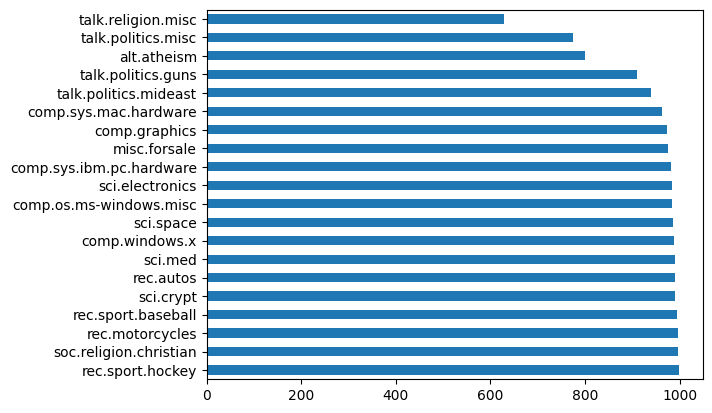

In [16]:
for label_index in range(number_of_unique_labels):
    print('{}: {}'.format(label_index, df.label[label_index]))
    
df.label.value_counts().plot.barh()

Below we provide an example of samples taken from three different labels:

In [17]:
print('First example: sample number {} (label: {})\n\n{}\n'.format(
    200, df.label[200], df.text[200]))
print('-' * 64)
print('Second example: sample number {} (label: {})\n\n{}\n'.format(
    1000, df.label[1000], df.text[1000]))
print('-' * 64)
print('Third example: sample number {} (label: {})\n\n{}\n'.format(
    4444, df.label[4444], df.text[4444]))

First example: sample number 200 (label: sci.electronics)

Does anyone know what causes the ever-growing black border around the
edges of my computer screen?  The growth has been gradual so I don't
know how long it's taken to get this bad.  I have a 19" DEC (?)
color monitor, maybe five years old, and the black border is about 1.1
inches on the left and right sides, about 1.75 inches on the bottom and
negligible at the top of the screen.  The only controls are
brightness knob, contrast knob, deGauss switch, and power switch.

Is there anything to be done, or are the monitor's days numbered?

----------------------------------------------------------------
Second example: sample number 1000 (label: talk.politics.misc)


The speed limit on commuter tracks in the northeast is 120MPH.  We
already have something that resembles high speed rail in this
country and it requires massive government subsidies.  We don't need
another government boondoggle.

-----------------------------------------

In [18]:
def keep_only_alphas(text):
    return ' '.join(re.findall("[a-zA-Z]+", text))
df['text'] = df['text'].apply(keep_only_alphas)

In [19]:
def set_to_lowercase(text):
    return text.lower()
df['text'] = df['text'].apply(set_to_lowercase)

In [20]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
    
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

print(stop_words)

df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))



[nltk_data] Downloading package stopwords to
[nltk_data]     /home/guillaume/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


{'themselves', 'here', 'against', 'each', 'does', 'was', 'that', "shan't", "couldn't", 'm', 'this', 'down', 'couldn', 'then', 'aren', 'him', 're', 'yours', "haven't", "isn't", 'before', 'be', 'himself', 'again', 'shan', 'where', 'needn', 'won', "you're", "she's", "aren't", 'mustn', 'y', 'once', 'ma', 'did', 'should', 'he', 'weren', 'mightn', 'now', 'my', "you'd", 'can', "wouldn't", "hadn't", 'those', 'hers', 'wouldn', 'nor', 'into', 'will', 'isn', 'is', 'itself', 'his', "mustn't", 'because', 'more', "won't", 'hasn', 'above', "needn't", 'are', 'if', "doesn't", 'to', 'out', 't', 'of', 'all', 'such', "mightn't", 've', 'them', 'which', 'herself', 'than', "wasn't", 'with', 'd', 'it', 'so', "it's", 'same', 's', 'how', 'no', 'own', 'but', 'your', 'the', 'were', 'doing', 'in', 'most', 'hadn', 'wasn', 'over', 'didn', 'our', 'she', 'there', "didn't", 'while', 'a', 'some', 'being', 'i', 'me', 'by', 'shouldn', 'about', 'o', 'through', 'very', 'until', 'had', "shouldn't", 'who', 'both', 'her', 'why

In [21]:
print('First example: sample number {} (label: {})\n\n{}\n'.format(
    200, df.label[200], df.text[200]))

First example: sample number 200 (label: sci.electronics)

anyone know causes ever growing black border around edges computer screen growth gradual know long taken get bad dec color monitor maybe five years old black border inches left right sides inches bottom negligible top screen controls brightness knob contrast knob degauss switch power switch anything done monitor days numbered



In [23]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['text'])
print(X)

  (0, 73686)	0.15187832786720926
  (0, 37276)	0.22447517405767933
  (0, 89948)	0.3014235737393504
  (0, 46709)	0.35034339928025676
  (0, 20366)	0.36349064549265675
  (0, 3700)	0.23042204875359285
  (0, 79039)	0.21184604634639903
  (0, 63064)	0.5055312870573218
  (0, 15407)	0.4136978972966732
  (0, 58930)	0.23694060826374794
  (1, 62185)	0.09836763707120093
  (1, 59301)	0.07666375622716304
  (1, 2258)	0.10952476800969671
  (1, 59363)	0.1519922097394126
  (1, 24978)	0.1165766450724833
  (1, 54360)	0.15566489943514464
  (1, 14818)	0.09547267625117296
  (1, 38116)	0.12917537732211745
  (1, 61381)	0.08827663302149648
  (1, 86629)	0.07724978821269096
  (1, 29992)	0.0763950340866983
  (1, 54896)	0.2618189837542811
  (1, 3654)	0.08401125237838675
  (1, 67787)	0.269577155669678
  (1, 72521)	0.06678007045314009
  :	:
  (18845, 80863)	0.07850989048845489
  (18845, 54564)	0.11269519564478395
  (18845, 88065)	0.14360454144577917
  (18845, 67377)	0.14177947669372862
  (18845, 25561)	0.12627845371109

In [ ]:
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

tokens = word_tokenize(dataset.data[1])
print(tokens)